In [3]:
# Install required packages
!pip install wandb --quiet
import wandb
wandb.login()  # You will be prompted to log in


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gvasusuresh004 (gvasusuresh004-intellipaat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
# # Unzip only once if not already done
# !unzip -q dataset.zip -d .

# # Check files
# import os
# # os.listdir("dataset/dataset/training/inputs")


###  **1. Importing Required Libraries**
We import essential libraries for file handling, image processing, data loading, modeling, and visualization.
###  **2. Setting Random Seed and Device**
We set seeds for reproducibility and assign the computation device (GPU if available).



In [5]:
import os
import json
import random
import numpy as np
from PIL import Image, ImageEnhance

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# Set seed
random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **3. Define Color Map and Utility Function**
This block defines RGB values for each color name and a utility function to create a color image tensor for conditioning.


In [6]:
COLOR_MAP = {
    'red': [1, 0, 0],
    'green': [0, 1, 0],
    'blue': [0, 0, 1],
    'yellow': [1, 1, 0],
    'cyan': [0, 1, 1],
    'magenta': [1, 0, 1],
    'black': [0, 0, 0],
    'white': [1, 1, 1],
    'orange': [1, 0.5, 0], # Add orange to the color map
    'purple': [0.5, 0, 0.5], # Add purple to the color map
}
def get_color_tensor(color_name, size=(128, 128)):
    color = COLOR_MAP[color_name.lower()]
    color_array = np.array(color, dtype=np.uint8).reshape(1, 3, 1, 1)
    color_image = np.tile(color_array, (1, 1, size[0], size[1])) / 255.0
    return torch.tensor(color_image, dtype=torch.float32).squeeze(0)

### **4. Custom Dataset Class (`PolygonColorDataset`)**
This custom PyTorch `Dataset` loads input polygon images, color conditions, and output images. It forms a 6-channel input by concatenating the polygon and color image.


In [7]:
class PolygonColorDataset(Dataset):
    def __init__(self, data_dir, json_file, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        with open(json_file) as f:
            self.data = json.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_path = os.path.join(self.data_dir, 'inputs', item['input_polygon'])
        output_path = os.path.join(self.data_dir, 'outputs', item['output_image'])
        color_name = item['colour']

        input_img = Image.open(input_path).convert('RGB')
        output_img = Image.open(output_path).convert('RGB')

        if self.transform:
            input_img = self.transform(input_img)
            output_img = self.transform(output_img)

        color_tensor = get_color_tensor(color_name)
        combined_input = torch.cat((input_img, color_tensor), dim=0)  # Shape: [6, H, W]

        return combined_input, output_img


### **5. Define Transformations and Create Datasets**
We apply resizing and normalization transforms and create training/validation dataset instances.
###  **6. Creating DataLoaders**
We use PyTorch `DataLoader` to load data in mini-batches for both training and validation.



In [8]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = PolygonColorDataset(
    data_dir='dataset/training',
    json_file='dataset/training/data.json',
    transform=transform
)

val_dataset = PolygonColorDataset(
    data_dir='dataset/validation',
    json_file='dataset/validation/data.json',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


### **7. UNet Block Definition**
This defines a reusable convolutional block consisting of Conv2d, BatchNorm, and ReLU layers used throughout the UNet architecture.
### **8. Full UNet Architecture**
Here, we define the UNet model with encoder-decoder structure and skip connections. It takes 6-channel input and outputs a 3-channel RGB image.



In [9]:
class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = UNetBlock(6, 64)
        self.enc2 = UNetBlock(64, 128)
        self.enc3 = UNetBlock(128, 256)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = UNetBlock(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = UNetBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = UNetBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = UNetBlock(128, 64)

        self.final = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)


### **9. Model Initialization and Training Configuration**
We initialize the UNet model, set the loss function (L1 loss), and define the optimizer (Adam).
### **10. Training Loop**
Performs training for a fixed number of epochs. Tracks training and validation loss across epochs and prints them.



In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()

for epoch in range(100):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Train Loss: {total_loss / len(train_loader):.4f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")


Epoch 1, Train Loss: 1.0101
Validation Loss: 0.9788
Epoch 2, Train Loss: 0.9090
Validation Loss: 0.9387
Epoch 3, Train Loss: 0.8499
Validation Loss: 0.8816
Epoch 4, Train Loss: 0.8035
Validation Loss: 0.8274
Epoch 5, Train Loss: 0.7629
Validation Loss: 0.7764
Epoch 6, Train Loss: 0.7176
Validation Loss: 0.7161
Epoch 7, Train Loss: 0.6708
Validation Loss: 0.6634
Epoch 8, Train Loss: 0.6331
Validation Loss: 0.6174
Epoch 9, Train Loss: 0.6044
Validation Loss: 0.5768
Epoch 10, Train Loss: 0.5763
Validation Loss: 0.5377
Epoch 11, Train Loss: 0.5562
Validation Loss: 0.5291
Epoch 12, Train Loss: 0.5337
Validation Loss: 0.5039
Epoch 13, Train Loss: 0.5109
Validation Loss: 0.4849
Epoch 14, Train Loss: 0.4966
Validation Loss: 0.4692
Epoch 15, Train Loss: 0.4754
Validation Loss: 0.4611
Epoch 16, Train Loss: 0.4579
Validation Loss: 0.4297
Epoch 17, Train Loss: 0.4384
Validation Loss: 0.4057
Epoch 18, Train Loss: 0.4243
Validation Loss: 0.3946
Epoch 19, Train Loss: 0.4070
Validation Loss: 0.3826
Ep

### **11. Prediction and Visualization Utility**
Defines a helper function to display a sample prediction alongside its input polygon and ground truth output.
### **12. Visualize Sample Prediction**
We apply the trained model to a sample from the validation set and display the prediction vs. ground truth.




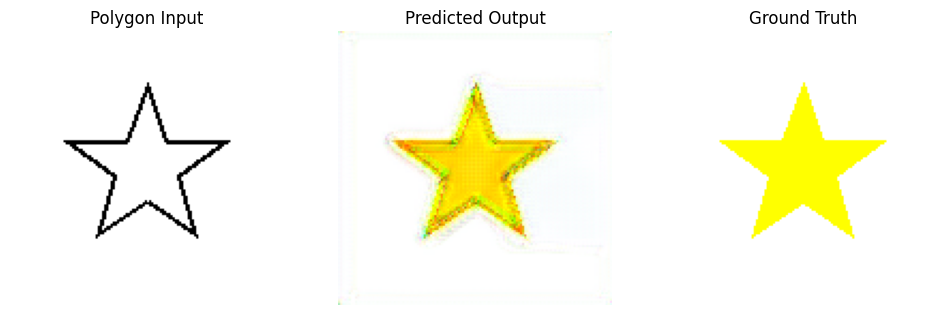

In [11]:
def predict_and_show(model, dataset, index=0):
    model.eval()
    with torch.no_grad():
        input_tensor, target_tensor = dataset[index]
        input_tensor = input_tensor.unsqueeze(0).to(device)
        pred = model(input_tensor).squeeze(0).cpu().permute(1, 2, 0).numpy()
        pred = np.clip(pred, 0, 1)

        input_image = input_tensor[0, :3].cpu().permute(1, 2, 0).numpy()
        target_image = target_tensor.permute(1, 2, 0).numpy()

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(input_image)
        axs[0].set_title("Polygon Input")
        axs[1].imshow(pred)
        axs[1].set_title("Predicted Output")
        axs[2].imshow(target_image)
        axs[2].set_title("Ground Truth")
        for ax in axs:
            ax.axis('off')
        plt.show()

# Example usage
predict_and_show(model, val_dataset, index=0)
import cv2
import numpy as np



### **13. Import and Configure wandb**
We import Weights & Biases (W&B), login (if not already), and configure the project to log metrics and images.
### **16. Saving the Trained Model**
Saves the final trained model to disk and logs it as an artifact on W&B for reproducibility or deployment.


In [12]:
import torch
import torch.nn as nn
import wandb
import torchvision.utils as vutils

# Initialize wandb
wandb.init(
    project="polygon-color-unet",
    name="UNet-train-run",
    config={
        "architecture": "UNet",
        "loss_function": "L1Loss",
        "optimizer": "Adam",
        "learning_rate": 1e-4,
        "epochs": 100,
        "batch_size": train_loader.batch_size,
        "input_size": "128x128"
    }
)

# Set device and training components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=wandb.config.learning_rate)
criterion = nn.L1Loss()

# Training loop
for epoch in range(wandb.config.epochs):
    model.train()
    total_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()

    avg_val_loss = val_loss / len(val_loader)

    # Log scalar metrics
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss
    })

    # OPTIONAL: Log sample predictions to W&B (1st batch only)
    if epoch % 10 == 0 or epoch == wandb.config.epochs - 1:
        input_vis = val_inputs[0][:3]  # First image input polygon (3 channels)
        pred_vis = val_outputs[0].clamp(0, 1)  # Clamp to valid range
        target_vis = val_targets[0]

        # Concatenate and send to wandb
        wandb.log({
            "sample_input": wandb.Image(input_vis.cpu(), caption="Polygon Input"),
            "sample_prediction": wandb.Image(pred_vis.cpu(), caption="Predicted Output"),
            "sample_ground_truth": wandb.Image(target_vis.cpu(), caption="Ground Truth")
        })

    print(f"Epoch [{epoch+1}/{wandb.config.epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# Save model
torch.save(model.state_dict(), "latestmodel.pth")
wandb.save("latestmodel.pth")


Epoch [1/100] | Train Loss: 0.7694 | Val Loss: 0.9108
Epoch [2/100] | Train Loss: 0.6381 | Val Loss: 0.8262
Epoch [3/100] | Train Loss: 0.5652 | Val Loss: 0.7027
Epoch [4/100] | Train Loss: 0.5031 | Val Loss: 0.5497
Epoch [5/100] | Train Loss: 0.4514 | Val Loss: 0.4701
Epoch [6/100] | Train Loss: 0.4074 | Val Loss: 0.3897
Epoch [7/100] | Train Loss: 0.3724 | Val Loss: 0.3435
Epoch [8/100] | Train Loss: 0.3437 | Val Loss: 0.3180
Epoch [9/100] | Train Loss: 0.3190 | Val Loss: 0.2988
Epoch [10/100] | Train Loss: 0.2935 | Val Loss: 0.2802
Epoch [11/100] | Train Loss: 0.2698 | Val Loss: 0.2504
Epoch [12/100] | Train Loss: 0.2491 | Val Loss: 0.2238
Epoch [13/100] | Train Loss: 0.2385 | Val Loss: 0.2267
Epoch [14/100] | Train Loss: 0.2152 | Val Loss: 0.1986
Epoch [15/100] | Train Loss: 0.2062 | Val Loss: 0.1831
Epoch [16/100] | Train Loss: 0.1894 | Val Loss: 0.1848
Epoch [17/100] | Train Loss: 0.1723 | Val Loss: 0.1678
Epoch [18/100] | Train Loss: 0.1651 | Val Loss: 0.1749
Epoch [19/100] | Tr

['/content/wandb/run-20250803_075318-hbr5iu4b/files/latestmodel.pth']